<a href="https://colab.research.google.com/github/mjhoover1/Robust_MAML/blob/main/MAML_pytorch_only_omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
!pip install easyfsl

In [1]:
# Import modules we need
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import glob
from tqdm import tqdm
import numpy as np
from collections import OrderedDict
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
import random
from easyfsl.data_tools import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# # 5 n-way 5 k-shot
# def randomSelectSamples(data, samples):

#     randomlist = random.sample(range(0, len(data.targets)-1), min(len(data.targets), samples))
#     data.targets = [data.targets[i] for i in randomlist]
#     data.data = [data.data[i] for i in randomlist]
    
#     return data

# def randomSelectSamplesByClasses(data, classes, sample_size):

#     randomlist = random.sample(range(0, len(data.targets)), min(len(data.targets), 100*len(classes)*sample_size))
#     counter_by_class = {}
#     new_index_list = []
#     for i in randomlist:
#         if(data.targets[i] not in counter_by_class):
#             counter_by_class[data.targets[i]] = 1
#             new_index_list.append(i)
        
#         elif(counter_by_class[data.targets[i]] < sample_size):
#             counter_by_class[data.targets[i]] += 1
#             new_index_list.append(i)
            
#     data.targets = [data.targets[i] for i in new_index_list]
#     data.data = [data.data[i] for i in new_index_list]
#     print(data.targets)
#     return data

In [4]:
import torchvision.transforms as transforms
from    PIL import Image
import  os.path
import  numpy as np

# imgsz=64
# image_size = 28

# transform = Compose([
#                     lambda x: x.resize((imgsz, imgsz)),
#                     lambda x: np.reshape(x, (imgsz, imgsz, 1)),
#                     lambda x: np.transpose(x, [2, 0, 1]),
#                     lambda x: x/255.])
# transform1 = Compose(
#     [
#      transforms.Grayscale(num_output_channels=1), # Omniglot has 1 channel
#      transforms.RandomResizedCrop(image_size),
#      transforms.RandomHorizontalFlip(),
#      transforms.ToTensor()
#      ])
# transform2 = Compose(
#     [
#      transforms.Grayscale(num_output_channels=1), # Omniglot has 1 channel
#      transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
#      transforms.CenterCrop(image_size),
#      transforms.ToTensor()
#      ])
transform3 = Compose(
    [
     transforms.ToTensor()
     ])

In [5]:
training_set = datasets.Omniglot(
    root="data",
    background=True, # selects train set
    download=True, 
    transform=transform3
)

test_set = datasets.Omniglot(
    root="data",
    background=False, # selects the test set
    download=True, 
    transform=transform3
)

Files already downloaded and verified
Files already downloaded and verified


image.shape: torch.Size([1, 105, 105])
Label: 0


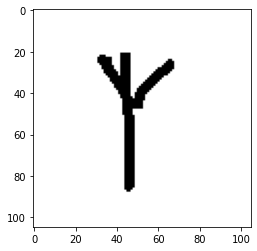

In [6]:
%matplotlib inline
image, label = training_set[0]
print('image.shape:', image.shape)
plt.imshow(image[0],cmap='gray')
print('Label:', label)

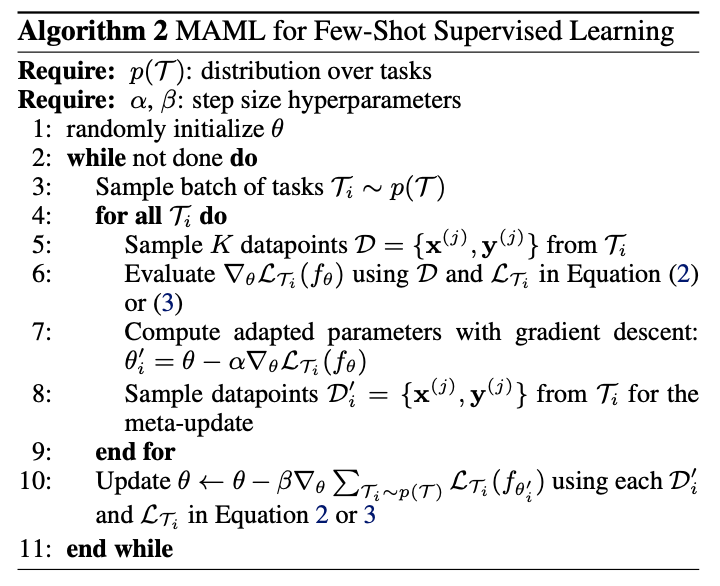

In [7]:
def ConvBlock(in_ch, out_ch):
  return nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding = 1),
                       nn.BatchNorm2d(out_ch),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size = 2, stride = 2)) # 原作者在 paper 裡是说她在 omniglot 用的是 strided convolution
                                                                  # 不过这裡我改成 max pool (mini imagenet 才是 max pool)
                                                                  # 这并不是你们在 report 第三题要找的 tip
def ConvBlockFunction(x, w, b, w_bn, b_bn):
  x = F.conv2d(x, w, b, padding = 1)
  x = F.batch_norm(x, running_mean = None, running_var = None, weight = w_bn, bias = b_bn, training = True)
  x = F.relu(x)
  x = F.max_pool2d(x, kernel_size = 2, stride = 2)
  return x

class Classifier(nn.Module):
  def __init__(self, in_ch, k_way):
    super(Classifier, self).__init__()
    self.conv1 = ConvBlock(in_ch, 64)
    self.conv2 = ConvBlock(64, 64)
    self.conv3 = ConvBlock(64, 64)
    self.conv4 = ConvBlock(64, 64)
    self.logits = nn.Linear(64, k_way)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.logits(x)
    return x

  def functional_forward(self, x, params):
    '''
    Arguments:
    x: input images [batch, 1, 28, 28]
    params: convolution, weight, bias，batchnormalization, weight, bias
            OrderedDict
    '''
    for block in [1, 2, 3, 4]:
      x = ConvBlockFunction(x, params[f'conv{block}.0.weight'], params[f'conv{block}.0.bias'],
                            params.get(f'conv{block}.1.weight'), params.get(f'conv{block}.1.bias'))
    x = x.view(x.shape[0], -1)
    x = F.linear(x, params['logits.weight'] , params['logits.bias'])
    return x

In [8]:
n_way = 5
k_shot = 1
q_query = 1
inner_train_step = 1
inner_lr = 0.4
meta_lr = 0.001
meta_batch_size = 32
max_epoch = 40
eval_batches = test_batches = 20
# N_WAY = 5 # Number of classes in a task
# N_SHOT = 5 # Number of images per class in the support set
# N_QUERY = 10 # Number of images per class in the query set
# N_EVALUATION_TASKS = 100

# # The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
# test_set.labels = [instance[1] for instance in test_set._flat_character_images]
# test_sampler = TaskSampler(
#     test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
# )

# test_loader = DataLoader(
#     test_set,
#     batch_sampler=test_sampler,
#     num_workers=12,
#     pin_memory=True,
#     collate_fn=test_sampler.episodic_collate_fn,
# )

In [12]:
# (
#     example_support_images,
#     example_support_labels,
#     example_query_images,
#     example_query_labels,
#     example_class_ids,
# ) = next(iter(test_loader))

# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

NameError: ignored

In [20]:
# meta_model.eval()
# example_scores = meta_model(
#     example_support_images.cuda(),
#     example_support_labels.cuda(),
#     example_query_images.cuda(),
# ).detach()

# _, example_predicted_labels = torch.max(example_scores.data, 1)

# print("Ground Truth / Predicted")
# for i in range(len(example_query_labels)):
#     print(
#         f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
#     )

TypeError: ignored

In [9]:
meta_model = Classifier(1, n_way).cuda()
optimizer = torch.optim.Adam(meta_model.parameters(), lr = meta_lr)
loss_fn = nn.CrossEntropyLoss().cuda()

In [ ]:
# class_choosen = [0,1,2,3,4]
# boolean_array_train = [label in class_choosen for img, label in training_data]
# boolean_array_test = [label in class_choosen for img, label in test_data]

# training_data.data = [img for img, label in training_data]
# training_data.targets = [label for img, label in training_data]

# training_data.data = list(compress(training_data.data,boolean_array_train))
# training_data.targets = list(compress(training_data.targets,boolean_array_train))

# test_data.data = [img for img, label in test_data]
# test_data.targets = [label for img, label in test_data]

# test_data.data = list(compress(test_data.data,boolean_array_test))
# test_data.targets = list(compress(test_data.targets,boolean_array_test))

# Task_1 = {}
# Task_1['query'] = randomSelectSamples(test_data, 5)
# Task_1['support'] = randomSelectSamplesByClasses(training_data, class_choosen,5)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device

Terminology:

* k-way: We are given k classes (e.g. 5-way means 5 classes)
* k-shot: the number of k samples per class (e.g. 1-shot means 1 sample per class)
* support-set: the j*k samples we can use for learning
* query-set (aka target-set): additional samples (number can vary)
* task: support + query sets (used in different ways by different methods)
* training: random tasks (both support and query have associated labels)
* test: new unseen task (given the support labels predict the query labels); query set no longer has labels.

Omniglot: 1623 handwritten characters from 50 different alphabets, from 20 different people. Each image is 105 x 105 x 1. The training set contains 964 handwritten characters from 20 people, so the actual size of the training set is 964*20.

Support set could be randomly picking one character from each alphabet, or consider the same characters from the same alphabet. 

In [10]:
def ConvBlock(in_ch, out_ch):
  return nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding = 1),
                       nn.BatchNorm2d(out_ch),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size = 2, stride = 2))  
  
def ConvBlockFunction(x, w, b, w_bn, b_bn):
  x = F.conv2d(x, w, b, padding = 1)
  x = F.batch_norm(x, running_mean = None, running_var = None, weight = w_bn, bias = b_bn, training = True)
  x = F.relu(x)
  x = F.max_pool2d(x, kernel_size = 2, stride = 2)
  return x

class Classifier(nn.Module):
  def __init__(self, in_ch, k_way):
    super(Classifier, self).__init__()
    self.conv1 = ConvBlock(in_ch, 64)
    self.conv2 = ConvBlock(64, 64)
    self.conv3 = ConvBlock(64, 64)
    self.conv4 = ConvBlock(64, 64)
    self.logits = nn.Linear(64, k_way)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.logits(x)
    return x

  def functional_forward(self, x, params):
    for block in [1, 2, 3, 4]:
      x = ConvBlockFunction(x, params[f'conv{block}.0.weight'], params[f'conv{block}.0.bias'],
                            params.get(f'conv{block}.1.weight'), params.get(f'conv{block}.1.bias'))
    x = x.view(x.shape[0], -1)
    x = F.linear(x, params['logits.weight'] , params['logits.bias'])
    return x

In [11]:
def create_label(n_way, k_shot):
  return torch.arange(n_way).repeat_interleave(k_shot).long()
  
# 5 way 5 shot
create_label(n_way, k_shot)

tensor([0, 1, 2, 3, 4])

In [12]:
def MAML(model, optimizer, x, n_way, k_shot, q_query, loss_fn, inner_train_step = 1, inner_lr = 0.4, train = True):
  """
  Args:
  x is the input omniglot images for a meta_step, shape = [batch_size, n_way * (k_shot + q_query), 1, 28, 28]
  n_way: Per category task How many class
  k_shot: Each category is in training How many photos will there be
  q_query: exist testing When, how many photos will be used in each category update
  """
  print(x.shape)
  criterion = loss_fn
  task_loss = []  
  task_acc = []  
  for meta_batch in x:
    train_set = meta_batch[:n_way*k_shot] # train_set We brought it update inner loop 参数的 data
    val_set = meta_batch[n_way*k_shot:]   # val_set 是我们拿来 update outer loop 参数的 data
    
    fast_weights = OrderedDict(model.named_parameters()) # 在 inner loop update 参数时，我们不能动到实际参数，因此用 fast_weights 来储存新的参数 θ'
    
    for inner_step in range(inner_train_step): # 这个 for loop 是 Algorithm2 的 line 7~8
                                                # 实际上我们 inner loop 只有 update 一次 gradients，不过某些 task 可能会需要多次 update inner loop 的 θ'，
                                                # 所以我们还是用 for loop 来写
      train_label = create_label(n_way, k_shot).cuda()
      logits = model.functional_forward(train_set, fast_weights)
      loss = criterion(logits, train_label)
      grads = torch.autograd.grad(loss, fast_weights.values(), create_graph = True) # 这裡是要计算出 loss 对 θ 的微分 (∇loss)    
      fast_weights = OrderedDict((name, param - inner_lr * grad)
                                  for ((name, param), grad) in zip(fast_weights.items(), grads)) # 这裡是用刚刚算出的 ∇loss 来 update θ 变成 θ'
  
    val_label = create_label(n_way, q_query).cuda()
    logits = model.functional_forward(val_set, fast_weights) # 这裡用 val_set 和 θ' 算 logit
    loss = criterion(logits, val_label)                      # 这裡用 val_set 和 θ' 算 loss
    task_loss.append(loss)                                   # 把这个 task 的 loss 丢进 task_loss 裡面
    acc = np.asarray([torch.argmax(logits, -1).cpu().numpy() == val_label.cpu().numpy()]).mean() # 算 accuracy
    task_acc.append(acc)
    
  model.train()
  optimizer.zero_grad()
  meta_batch_loss = torch.stack(task_loss).mean() # 我们要用一整个 batch 的 loss 来 update θ (不是 θ')
  if train:
    meta_batch_loss.backward()
    optimizer.step()
  task_acc = np.mean(task_acc)
  return meta_batch_loss, task_acc

In [58]:
class Omniglot(Dataset):
  def __init__(self, data_dir, k_way, q_query):
    self.file_list = [f for f in glob.glob(data_dir + "**/character*", recursive=True)]
    self.transform = transforms.Compose([transforms.ToTensor()])
    self.n = k_way + q_query
  def __getitem__(self, idx):
    sample = np.arange(20)
    np.random.shuffle(sample) # 这裡是为了等一下要 random sample 出我们要的 character
    img_path = self.file_list[idx]
    img_list = [f for f in glob.glob(img_path + "**/*.png", recursive=True)]
    img_list.sort()
    imgs = [self.transform(Image.open(img_file)) for img_file in img_list]
    imgs = torch.stack(imgs)[sample[:self.n]] # 每个 character，取出 k_way + q_query 个
    return imgs
  def __len__(self):
    return len(self.file_list)  

In [14]:
val_size = int(len(training_set)*.2)
train_size = int(len(training_set) - val_size)
train_size

15424

In [22]:
train_set, val_set = torch.utils.data.random_split(training_set, [train_size,val_size])

In [23]:
train_loader = DataLoader(train_set,
                          batch_size = n_way, 
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
val_loader = DataLoader(val_set,
                          batch_size = n_way,
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
test_loader = DataLoader(test_set,
                          batch_size = n_way,
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
train_iter = iter(train_loader)
val_iter = iter(val_loader)
test_iter = iter(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
def get_meta_batch(meta_batch_size, k_shot, q_query, data_loader, iterator):
  data = []
  for _ in range(meta_batch_size):
    try:
      task_data = iterator.next()  # 一笔 task_data: task, data [n_way, k_shot+q_query, 1, 28, 28]
    except StopIteration:
      print("Oh")
      iterator = iter(data_loader)
      task_data = iterator.next()
    train_data = task_data[0][:k_shot].reshape(-1, 1, 105, 105)
    # train_data = task_data[:, :k_shot].reshape(-1, 1, 28, 28)
    val_data = task_data[0][k_shot:].reshape(-1, 1, 105, 105)
    # val_data = task_data[:, k_shot:].reshape(-1, 1, 28, 28)
    task_data = torch.cat((train_data, val_data), 0)
    data.append(task_data)
  return torch.stack(data).cuda(), iterator

In [25]:
for epoch in range(max_epoch):
  print("Epoch %d" %(epoch))
  train_meta_loss = []
  train_acc = []
  for step in tqdm(range(len(train_loader) // (meta_batch_size))): # 这裡的 step 是一次 meta-gradinet update step
    x, train_iter = get_meta_batch(meta_batch_size, k_shot, q_query, train_loader, train_iter)
    meta_loss, acc = MAML(meta_model, optimizer, x, n_way, k_shot, q_query, loss_fn)
    train_meta_loss.append(meta_loss.item())
    train_acc.append(acc)
  print("  Loss    : ", np.mean(train_meta_loss))
  print("  Accuracy: ", np.mean(train_acc))

  # 每个 epoch 结束后，看看 validation accuracy 如何  
  # 助教并没有做 early stopping，同学如果觉得有需要是可以做的 
  val_acc = []
  for eval_step in tqdm(range(len(val_loader) // (eval_batches))):
    x, val_iter = get_meta_batch(eval_batches, k_shot, q_query, val_loader, val_iter)
    _, acc = MAML(meta_model, optimizer, x, n_way, k_shot, q_query, loss_fn, inner_train_step = 3, train = False) # testing时，我们更新三次 inner-step
    val_acc.append(acc)
  print("  Validation accuracy: ", np.mean(val_acc))

Epoch 0


  0%|          | 0/96 [00:00<?, ?it/s]

torch.Size([32, 5, 1, 105, 105])


RuntimeError: ignored

In [23]:
import  torch
from    torch import nn
from    torch.nn import functional as F
import  numpy as np



# """Taken From:

# @misc{MAML_Pytorch,
#   author = {Liangqu Long},
#   title = {MAML-Pytorch Implementation},
#   year = {2018},
#   publisher = {GitHub},
#   journal = {GitHub repository},
#   howpublished = {\url{https://github.com/dragen1860/MAML-Pytorch}},
#   commit = {master}
# }

# """
class Learner(nn.Module):
    def __init__(self, config, imgc, imgsz):
        """
        :param config: network config file, type:list of (string, list)
        :param imgc: 1 or 3
        :param imgsz:  28 or 84
        """
        super(Learner, self).__init__()


        self.config = config

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        for i, (name, param) in enumerate(self.config):
            if name is 'conv2d':
                # [ch_out, ch_in, kernelsz, kernelsz]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'convt2d':
                # [ch_in, ch_out, kernelsz, kernelsz, stride, padding]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_in, ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[1])))

            elif name is 'linear':
                # [ch_out, ch_in]
                w = nn.Parameter(torch.ones(*param))
                # gain=1 according to cbfinn's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                # [ch_out]
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

                # must set requires_grad=False
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])


            elif name in ['tanh', 'relu', 'upsample', 'avg_pool2d', 'max_pool2d',
                          'flatten', 'reshape', 'leakyrelu', 'sigmoid']:
                continue
            else:
                raise NotImplementedError






    def extra_repr(self):
        info = ''

        for name, param in self.config:
            if name is 'conv2d':
                tmp = 'conv2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[1], param[0], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'convt2d':
                tmp = 'convTranspose2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[0], param[1], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'linear':
                tmp = 'linear:(in:%d, out:%d)'%(param[1], param[0])
                info += tmp + '\n'

            elif name is 'leakyrelu':
                tmp = 'leakyrelu:(slope:%f)'%(param[0])
                info += tmp + '\n'


            elif name is 'avg_pool2d':
                tmp = 'avg_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name is 'max_pool2d':
                tmp = 'max_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name in ['flatten', 'tanh', 'relu', 'upsample', 'reshape', 'sigmoid', 'use_logits', 'bn']:
                tmp = name + ':' + str(tuple(param))
                info += tmp + '\n'
            else:
                raise NotImplementedError

        return info



    def forward(self, x, vars=None, bn_training=True):
        """
        This function can be called by finetunning, however, in finetunning, we dont wish to update
        running_mean/running_var. Thought weights/bias of bn is updated, it has been separated by fast_weights.
        Indeed, to not update running_mean/running_var, we need set update_bn_statistics=False
        but weight/bias will be updated and not dirty initial theta parameters via fast_weiths.
        :param x: [b, 1, 28, 28]
        :param vars:
        :param bn_training: set False to not update
        :return: x, loss, likelihood, kld
        """

        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'convt2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv_transpose2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
                # print('forward:', idx, x.norm().item())
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2

            elif name is 'flatten':
                # print(x.shape)
                x = x.view(x.size(0), -1)
            elif name is 'reshape':
                # [b, 8] => [b, 2, 2, 2]
                x = x.view(x.size(0), *param)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'leakyrelu':
                x = F.leaky_relu(x, negative_slope=param[0], inplace=param[1])
            elif name is 'tanh':
                x = F.tanh(x)
            elif name is 'sigmoid':
                x = torch.sigmoid(x)
            elif name is 'upsample':
                x = F.upsample_nearest(x, scale_factor=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
            elif name is 'avg_pool2d':
                x = F.avg_pool2d(x, param[0], param[1], param[2])

            else:
                raise NotImplementedError

        # make sure variable is used properly
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)


        return x


    def zero_grad(self, vars=None):
        """
        :param vars:
        :return:
        """
        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars

In [ ]:
import  torch
from    torch import nn
from    torch import optim
from    torch.nn import functional as F
from    torch.utils.data import TensorDataset, DataLoader
from    torch import optim
import  numpy as np
from    copy import deepcopy

class Meta(nn.Module):
    """
    Meta Learner
    """
    def __init__(self, config, epoch=40000,n_way=5, k_spt=1, k_qry=15, imgsz=28, imgc=1, task_num=32, meta_lr=1e-3, update_lr = .4, update_step =5, update_step_test = 10):
        """
        :param args:
        """
        super(Meta, self).__init__()

        self.update_lr = update_lr
        self.meta_lr = meta_lr
        self.n_way = n_way
        self.k_spt = k_spt
        self.k_qry = k_qry
        self.task_num = task_num
        self.update_step = update_step
        self.update_step_test = update_step_test


        self.net = Learner(config, imgc, imgsz)
        self.meta_optim = optim.Adam(self.net.parameters(), lr=self.meta_lr)




    def clip_grad_by_norm_(self, grad, max_norm):
        """
        in-place gradient clipping.
        :param grad: list of gradients
        :param max_norm: maximum norm allowable
        :return:
        """

        total_norm = 0
        counter = 0
        for g in grad:
            param_norm = g.data.norm(2)
            total_norm += param_norm.item() ** 2
            counter += 1
        total_norm = total_norm ** (1. / 2)

        clip_coef = max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            for g in grad:
                g.data.mul_(clip_coef)

        return total_norm/counter


    def forward(self, x_spt, y_spt, x_qry, y_qry):
        """
        :param x_spt:   [b, setsz, c_, h, w]
        :param y_spt:   [b, setsz]
        :param x_qry:   [b, querysz, c_, h, w]
        :param y_qry:   [b, querysz]
        :return:
        """
        task_num, setsz, c_, h, w = x_spt.size()
        querysz = x_qry.size(1)

        losses_q = [0 for _ in range(self.update_step + 1)]  # losses_q[i] is the loss on step i
        corrects = [0 for _ in range(self.update_step + 1)]


        for i in range(task_num):

            # 1. run the i-th task and compute loss for k=0
            logits = self.net(x_spt[i], vars=None, bn_training=True)
            loss = F.cross_entropy(logits, y_spt[i])
            grad = torch.autograd.grad(loss, self.net.parameters())
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, self.net.parameters())))

            # this is the loss and accuracy before first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], self.net.parameters(), bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[0] += loss_q

                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[0] = corrects[0] + correct

            # this is the loss and accuracy after the first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[1] += loss_q
                # [setsz]
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[1] = corrects[1] + correct

            for k in range(1, self.update_step):
                # 1. run the i-th task and compute loss for k=1~K-1
                logits = self.net(x_spt[i], fast_weights, bn_training=True)
                loss = F.cross_entropy(logits, y_spt[i])
                # 2. compute grad on theta_pi
                grad = torch.autograd.grad(loss, fast_weights)
                # 3. theta_pi = theta_pi - train_lr * grad
                fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                # loss_q will be overwritten and just keep the loss_q on last update step.
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[k + 1] += loss_q

                with torch.no_grad():
                    pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                    correct = torch.eq(pred_q, y_qry[i]).sum().item()  # convert to numpy
                    corrects[k + 1] = corrects[k + 1] + correct



        # end of all tasks
        # sum over all losses on query set across all tasks
        loss_q = losses_q[-1] / task_num

        # optimize theta parameters
        self.meta_optim.zero_grad()
        loss_q.backward()
        # print('meta update')
        # for p in self.net.parameters()[:5]:
        # 	print(torch.norm(p).item())
        self.meta_optim.step()


        accs = np.array(corrects) / (querysz * task_num)

        return accs


    def finetunning(self, x_spt, y_spt, x_qry, y_qry):
        """
        :param x_spt:   [setsz, c_, h, w]
        :param y_spt:   [setsz]
        :param x_qry:   [querysz, c_, h, w]
        :param y_qry:   [querysz]
        :return:
        """
        assert len(x_spt.shape) == 4

        querysz = x_qry.size(0)

        corrects = [0 for _ in range(self.update_step_test + 1)]

        # in order to not ruin the state of running_mean/variance and bn_weight/bias
        # we finetunning on the copied model instead of self.net
        net = deepcopy(self.net)

        # 1. run the i-th task and compute loss for k=0
        logits = net(x_spt)
        loss = F.cross_entropy(logits, y_spt)
        grad = torch.autograd.grad(loss, net.parameters())
        fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, net.parameters())))

        # this is the loss and accuracy before first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, net.parameters(), bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[0] = corrects[0] + correct

        # this is the loss and accuracy after the first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, fast_weights, bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[1] = corrects[1] + correct

        for k in range(1, self.update_step_test):
            # 1. run the i-th task and compute loss for k=1~K-1
            logits = net(x_spt, fast_weights, bn_training=True)
            loss = F.cross_entropy(logits, y_spt)
            # 2. compute grad on theta_pi
            grad = torch.autograd.grad(loss, fast_weights)
            # 3. theta_pi = theta_pi - train_lr * grad
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

            logits_q = net(x_qry, fast_weights, bn_training=True)
            # loss_q will be overwritten and just keep the loss_q on last update step.
            loss_q = F.cross_entropy(logits_q, y_qry)

            with torch.no_grad():
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry).sum().item()  # convert to numpy
                corrects[k + 1] = corrects[k + 1] + correct


        del net

        accs = np.array(corrects) / querysz

        return accs

In [ ]:
epoch = 40000
n_way = 5
k_spt = 1
K_qry = 15
imgsz = 28
imgc = 1
task_num = 32
meta_lr = 1e-3
update_lr = .4
update_step = 5
update_step_test = 10

config = [
        ('conv2d', [64, 1, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 2, 2, 1, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('flatten', []),
        ('linear', [n_way, 64])
    ]

In [ ]:
maml = Meta(config).to(device)

tmp = filter(lambda x: x.requires_grad, maml.parameters())
print(tmp)

num = sum(map(lambda x: np.prod(x.shape), tmp))
print(num)

print(maml)
print('Total trainable tensors:', num)

dataloader_spt = DataLoader(Task_1['support'], batch_size = 25)
dataloader_qry = DataLoader(Task_1['query'], batch_size =5)

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [ ]:
n_ways = 5
# [ch_in, ch_out, kernelsz, kernelsz, stride, padding]

config = [
    ('conv2d', [25, 3, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [25]),
    ('conv2d', [25, 25, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [25]),
    ('conv2d', [25, 25, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [25]),
    ('conv2d', [25, 25, 2, 2, 1, 0]),
    ('relu', [True]),
    ('bn', [25]),
    ('flatten', []),
    ('linear', [n_ways, 100])
]

In [ ]:
model = Learner(config,3,32)
batch = [(dataloader_spt,dataloader_qry)]
meta_lr = 1e-3
meta_opt = torch.optim.SGD(model.parameters(), lr = meta_lr) # torch.optim.Adam
for batch in task_batch:     # sample batch of tasks
    outer_loss = 0
    for task in batch: 
        train_inputs, train_targets = iter(task[0]).next() # train_inputs, train_targets = task['support'] // input-output train pairs
        test_inputs, test_targets = iter(task[1]).next() # test_inputs, test_targets = task['query'] // input-output test pairs
        
        train_logits = model(train_inputs) 
        inner_loss = F.cross_entropy(train_logits, train_targets) # on train set
        model.zero_grad()
        grads = torch.autograd.grad(inner_loss, model.parameters()) #, create_graph = True)
        # params = OrderedDict()
        # for (name, param), grad in zip(model.meta_named_pars(), grads):
        #   params[name] = param - step_size * grad

        fast_weights = list(map(lambda p: p[1] - meta_lr * p[0], zip(grads, model.parameters())))

        test_logits = model(test_inputs, fast_weights) #, params = params) // assign params to model
        # Notice the '+=' which is used to acumulate the loss for each task 
        outer_loss += F.cross_entropy(test_logits, test_targets) # on test set

    meta_opt.zero_grad() # Not found in code
    outer_loss.backward()
    meta_opt.step()

In [ ]:
# old code
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
import random
from torchvision.datasets import Omniglot
from PIL import Image

Relevant sites for omniglot:

* https://paperswithcode.com/dataset/omniglot-1 contains benchmarks and code

* https://github.com/brendenlake/omniglot original github for the omniglot code

* https://github.com/dragen1860/MAML-Pytorch/blob/master/omniglotNShot.py omniglot implementation, but Image.open(x).convert('L') causes line 33 to have an error. If this line is commented out, then it works but line 46 ends up being the wrong shape. If both of these problems are ignored, then when attempting to make the boolean_array below for the choosen classes all indices end up being False.

* https://colab.research.google.com/github/cnielly/prototypical-networks-omniglot/blob/master/prototypical_networks_pytorch_omniglot.ipynb#scrollTo=RhDNMyG8AjOB An implementation using omniglot, but this model is a Protonet which isn't MAML so if this code is used to attained the data. One needs to determine how to use the model below with the data functions in this code.



In [ ]:
import torchvision.transforms as transforms
# transform = Compose(
#     [ToTensor(),
#      Normalize((0.5), (0.5))])
# dataset = Omniglot(root='data/', download=True, transform=transform)

In [ ]:
! npm install -g localtunnel
get_ipython().system_raw('/usr/local/bin/python -m pip install visdom')
get_ipython().system_raw('/usr/local/bin/python -m visdom.server -port 6006 >> visdomlog.txt 2>&1 &')
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')
import time
time.sleep(5)
! cat url.txt
import visdom
time.sleep(5)
vis = visdom.Visdom(port='6006')
print(vis)
time.sleep(3)
vis.text('testing')
! cat visdomlog.txt

[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 2.606s


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

your url is: https://selfish-kangaroo-36.loca.lt


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

/content/visdom/py/visdom/server.py:36: DeprecationWarning: zmq.eventloop.ioloop is deprecated in pyzmq 17. pyzmq now works with default tornado and asyncio eventloops.
  ioloop.install()  # Needs to happen before any tornado imports!
INFO:root:Application Started
INFO:tornado.access:200 POST /env/main (127.0.0.1) 2.40ms
INFO:tornado.access:101 GET /vis_socket (127.0.0.1) 0.66ms
INFO:root:Opened visdom socket from ip: 127.0.0.1
INFO:tornado.access:200 POST /events (127.0.0.1) 2.41ms


In [ ]:
import  torch.utils.data as data
import  os
import  os.path
import  errno


class Omniglot(data.Dataset):
    urls = [
        'https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip',
        'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip'
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    '''
    The items are (filename,category). The index of all the categories can be found in self.idx_classes
    Args:
    - root: the directory where the dataset will be stored
    - transform: how to transform the input
    - target_transform: how to transform the target
    - download: need to download the dataset
    '''

    def __init__(self, root, transform=None, target_transform=None, download=False):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        if not self._check_exists():
            if download:
                self.download()
            else:
                raise RuntimeError('Dataset not found.' + ' You can use download=True to download it')

        self.all_items = find_classes(os.path.join(self.root, self.processed_folder))
        self.idx_classes = index_classes(self.all_items)

    def __getitem__(self, index):
        filename = self.all_items[index][0]
        img = str.join('/', [self.all_items[index][2], filename])

        target = self.idx_classes[self.all_items[index][1]]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.all_items)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, "images_evaluation")) and \
               os.path.exists(os.path.join(self.root, self.processed_folder, "images_background"))

    def download(self):
        from six.moves import urllib
        import zipfile

        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('== Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            file_processed = os.path.join(self.root, self.processed_folder)
            print("== Unzip from " + file_path + " to " + file_processed)
            zip_ref = zipfile.ZipFile(file_path, 'r')
            zip_ref.extractall(file_processed)
            zip_ref.close()
        print("Download finished.")


def find_classes(root_dir):
    retour = []
    for (root, dirs, files) in os.walk(root_dir):
        for f in files:
            if (f.endswith("png")):
                r = root.split('/')
                lr = len(r)
                retour.append((f, r[lr - 2] + "/" + r[lr - 1], root))
    print("== Found %d items " % len(retour))
    return retour


def index_classes(items):
    idx = {}
    for i in items:
        if i[1] not in idx:
            idx[i[1]] = len(idx)
    print("== Found %d classes" % len(idx))
    return idx

In [ ]:
import  torchvision.transforms as transforms
from    PIL import Image
import  os.path
import  numpy as np

class OmniglotNShot:

    def __init__(self, root, batchsz, n_way, k_shot, k_query, imgsz):
        """
        Different from mnistNShot, the
        :param root:
        :param batchsz: task num
        :param n_way:
        :param k_shot:
        :param k_qry:
        :param imgsz:
        """

        self.resize = imgsz
        if not os.path.isfile(os.path.join(root, 'omniglot.npy')):
            # if root/data.npy does not exist, just download it
            self.x = Omniglot(root, download=True,
                              transform=transforms.Compose([lambda x: Image.open(x).convert('L'),
                                                            lambda x: x.resize((imgsz, imgsz)),
                                                            lambda x: np.reshape(x, (imgsz, imgsz, 1)),
                                                            lambda x: np.transpose(x, [2, 0, 1]),
                                                            lambda x: x/255.])
                              )

            temp = dict()  # {label:img1, img2..., 20 imgs, label2: img1, img2,... in total, 1623 label}
            for (img, label) in self.x:
                if label in temp.keys():
                    temp[label].append(img)
                else:
                    temp[label] = [img]

            self.x = []
            for label, imgs in temp.items():  # labels info deserted , each label contains 20imgs
                self.x.append(np.array(imgs))

            # as different class may have different number of imgs
            self.x = np.array(self.x).astype(np.float)  # [[20 imgs],..., 1623 classes in total]
            # each character contains 20 imgs
            print('data shape:', self.x.shape)  # [1623, 20, 84, 84, 1]
            temp = []  # Free memory
            # save all dataset into npy file.
            np.save(os.path.join(root, 'omniglot.npy'), self.x)
            print('write into omniglot.npy.')
        else:
            # if data.npy exists, just load it.
            self.x = np.load(os.path.join(root, 'omniglot.npy'))
            print('load from omniglot.npy.')

        # [1623, 20, 84, 84, 1]
        # TODO: can not shuffle here, we must keep training and test set distinct!
        self.x_train, self.x_test = self.x[:1200], self.x[1200:]

        # self.normalization()

        self.batchsz = batchsz
        self.n_cls = self.x.shape[0]  # 1623
        self.n_way = n_way  # n way
        self.k_shot = k_shot  # k shot
        self.k_query = k_query  # k query
        assert (k_shot + k_query) <=20

        # save pointer of current read batch in total cache
        self.indexes = {"train": 0, "test": 0}
        self.datasets = {"train": self.x_train, "test": self.x_test}  # original data cached
        print("DB: train", self.x_train.shape, "test", self.x_test.shape)

        self.datasets_cache = {"train": self.load_data_cache(self.datasets["train"]),  # current epoch data cached
                               "test": self.load_data_cache(self.datasets["test"])}

    def normalization(self):
        """
        Normalizes our data, to have a mean of 0 and sdt of 1
        """
        self.mean = np.mean(self.x_train)
        self.std = np.std(self.x_train)
        self.max = np.max(self.x_train)
        self.min = np.min(self.x_train)
        # print("before norm:", "mean", self.mean, "max", self.max, "min", self.min, "std", self.std)
        self.x_train = (self.x_train - self.mean) / self.std
        self.x_test = (self.x_test - self.mean) / self.std

        self.mean = np.mean(self.x_train)
        self.std = np.std(self.x_train)
        self.max = np.max(self.x_train)
        self.min = np.min(self.x_train)

    # print("after norm:", "mean", self.mean, "max", self.max, "min", self.min, "std", self.std)

    def load_data_cache(self, data_pack):
        """
        Collects several batches data for N-shot learning
        :param data_pack: [cls_num, 20, 84, 84, 1]
        :return: A list with [support_set_x, support_set_y, target_x, target_y] ready to be fed to our networks
        """
        #  take 5 way 1 shot as example: 5 * 1
        setsz = self.k_shot * self.n_way
        querysz = self.k_query * self.n_way
        data_cache = []

        # print('preload next 50 caches of batchsz of batch.')
        for sample in range(10):  # num of episodes

            x_spts, y_spts, x_qrys, y_qrys = [], [], [], []
            for i in range(self.batchsz):  # one batch means one set

                x_spt, y_spt, x_qry, y_qry = [], [], [], []
                selected_cls = np.random.choice(data_pack.shape[0], self.n_way, False)

                for j, cur_class in enumerate(selected_cls):

                    selected_img = np.random.choice(20, self.k_shot + self.k_query, False)

                    # meta-training and meta-test
                    x_spt.append(data_pack[cur_class][selected_img[:self.k_shot]])
                    x_qry.append(data_pack[cur_class][selected_img[self.k_shot:]])
                    y_spt.append([j for _ in range(self.k_shot)])
                    y_qry.append([j for _ in range(self.k_query)])

                # shuffle inside a batch
                perm = np.random.permutation(self.n_way * self.k_shot)
                x_spt = np.array(x_spt).reshape(self.n_way * self.k_shot, 1, self.resize, self.resize)[perm]
                y_spt = np.array(y_spt).reshape(self.n_way * self.k_shot)[perm]
                perm = np.random.permutation(self.n_way * self.k_query)
                x_qry = np.array(x_qry).reshape(self.n_way * self.k_query, 1, self.resize, self.resize)[perm]
                y_qry = np.array(y_qry).reshape(self.n_way * self.k_query)[perm]

                # append [sptsz, 1, 84, 84] => [b, setsz, 1, 84, 84]
                x_spts.append(x_spt)
                y_spts.append(y_spt)
                x_qrys.append(x_qry)
                y_qrys.append(y_qry)


            # [b, setsz, 1, 84, 84]
            x_spts = np.array(x_spts).astype(np.float32).reshape(self.batchsz, setsz, 1, self.resize, self.resize)
            y_spts = np.array(y_spts).astype(np.int).reshape(self.batchsz, setsz)
            # [b, qrysz, 1, 84, 84]
            x_qrys = np.array(x_qrys).astype(np.float32).reshape(self.batchsz, querysz, 1, self.resize, self.resize)
            y_qrys = np.array(y_qrys).astype(np.int).reshape(self.batchsz, querysz)

            data_cache.append([x_spts, y_spts, x_qrys, y_qrys])

        return data_cache

    def next(self, mode='train'):
        """
        Gets next batch from the dataset with name.
        :param mode: The name of the splitting (one of "train", "val", "test")
        :return:
        """
        # update cache if indexes is larger cached num
        if self.indexes[mode] >= len(self.datasets_cache[mode]):
            self.indexes[mode] = 0
            self.datasets_cache[mode] = self.load_data_cache(self.datasets[mode])

        next_batch = self.datasets_cache[mode][self.indexes[mode]]
        self.indexes[mode] += 1

        return next_batch



In [ ]:
from visdom import Visdom
import time
import numpy as np

try:
    viz = Visdom()

    assert viz.check_connection(timeout_seconds=3), \
        'No connection could be formed quickly'

    # image callback demo
    def show_color_image_window(color, win=None):
        image = np.full([3, 256, 256], color, dtype=float)
        return viz.image(
            image,
            opts=dict(title='Colors', caption='Press arrows to alter color.'),
            win=win
        )

    image_color = 0
    callback_image_window = show_color_image_window(image_color)

    def image_callback(event):
        global image_color
        if event['event_type'] == 'KeyPress':
            if event['key'] == 'ArrowRight':
                image_color = min(image_color + 0.2, 1)
            if event['key'] == 'ArrowLeft':
                image_color = max(image_color - 0.2, 0)
            show_color_image_window(image_color, callback_image_window)

    viz.register_event_handler(image_callback, callback_image_window)

    # text window with Callbacks
    txt = 'This is a write demo notepad. Type below. Delete clears text:<br>'
    callback_text_window = viz.text(txt)

    def type_callback(event):
        if event['event_type'] == 'KeyPress':
            curr_txt = event['pane_data']['content']
            if event['key'] == 'Enter':
                curr_txt += '<br>'
            elif event['key'] == 'Backspace':
                curr_txt = curr_txt[:-1]
            elif event['key'] == 'Delete':
                curr_txt = txt
            elif len(event['key']) == 1:
                curr_txt += event['key']
            viz.text(curr_txt, win=callback_text_window)

    viz.register_event_handler(type_callback, callback_text_window)

    # Properties window
    properties = [
        {'type': 'text', 'name': 'Text input', 'value': 'initial'},
        {'type': 'number', 'name': 'Number input', 'value': '12'},
        {'type': 'button', 'name': 'Button', 'value': 'Start'},
        {'type': 'checkbox', 'name': 'Checkbox', 'value': True},
        {'type': 'select', 'name': 'Select', 'value': 1, 'values': ['Red', 'Green', 'Blue']},
    ]

    properties_window = viz.properties(properties)

    def properties_callback(event):
        if event['event_type'] == 'PropertyUpdate':
            prop_id = event['propertyId']
            value = event['value']
            if prop_id == 0:
                new_value = value + '_updated'
            elif prop_id == 1:
                new_value = value + '0'
            elif prop_id == 2:
                new_value = 'Stop' if properties[prop_id]['value'] == 'Start' else 'Start'
            else:
                new_value = value
            properties[prop_id]['value'] = new_value
            viz.properties(properties, win=properties_window)
            viz.text("Updated: {} => {}".format(properties[event['propertyId']]['name'], str(event['value'])),
                     win=callback_text_window, append=True)

    viz.register_event_handler(properties_callback, properties_window)

    try:
        input = raw_input  # for Python 2 compatibility
    except NameError:
        pass
    input('Waiting for callbacks, press enter to quit.')
except BaseException as e:
    print(
        "The visdom experienced an exception while running: {}\n"
        "The demo displays up-to-date functionality with the GitHub version, "
        "which may not yet be pushed to pip. Please upgrade using "
        "`pip install -e .` or `easy_install .`\n"
        "If this does not resolve the problem, please open an issue on "
        "our GitHub.".format(repr(e))
    )

[Errno 99] Cannot assign requested address
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
Setting up a new session...
on_close() takes 1 positional argument but 3 were given
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connect

Exception in user code:
------------------------------------------------------------


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

waiting
waiting
waiting
waiting


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


waiting
waiting
waiting
waiting
waiting
waiting
waiting
waiting
waiting
waiting


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


waiting
waiting


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


waiting
waiting
waiting
waiting
waiting
waiting


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address


waiting
waiting


on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


waiting
waiting


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


waiting
waiting
waiting
waiting
The visdom experienced an exception while running: AssertionError('No connection could be formed quickly')
The demo displays up-to-date functionality with the GitHub version, which may not yet be pushed to pip. Please upgrade using `pip install -e .` or `easy_install .`
If this does not resolve the problem, please open an issue on our GitHub.


In [ ]:
import  time
import  torch
import  visdom
from tqdm import tqdm

# plt.ion()
viz = visdom.Visdom()

# db = OmniglotNShot('db/omniglot', batchsz=20, n_way=5, k_shot=5, k_query=15, imgsz=64)

# for i in tqdm(range(1)):
#         x_spt, y_spt, x_qry, y_qry = db.next('train')


#         # [b, setsz, h, w, c] => [b, setsz, c, w, h] => [b, setsz, 3c, w, h]
#         x_spt = torch.from_numpy(x_spt)
#         x_qry = torch.from_numpy(x_qry)
#         y_spt = torch.from_numpy(y_spt)
#         y_qry = torch.from_numpy(y_qry)
#         batchsz, setsz, c, h, w = x_spt.size()


#         viz.images(x_spt[0], nrow=5, win='x_spt', opts=dict(title='x_spt'))
#         viz.images(x_qry[0], nrow=15, win='x_qry', opts=dict(title='x_qry'))
#         viz.text(str(y_spt[0]), win='y_spt', opts=dict(title='y_spt'))
#         viz.text(str(y_qry[0]), win='y_qry', opts=dict(title='y_qry'))

Setting up a new session...
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.7/http/client.py", line 1281, in request
    self._send_request(method, url, body

Exception in user code:
------------------------------------------------------------


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

KeyboardInterrupt: ignored

In [ ]:
ds = Omniglot('data/', download=True, transform=Compose([lambda x: Image.open(x).convert('L'),
                                                         lambda x: x.resize((64, 64)),
                                                         lambda x: np.reshape(x, (64, 64, 1)),
                                                         lambda x: np.transpose(x, [2, 0, 1]),
                                                         lambda x: x/255.])
)

Files already downloaded and verified


In [ ]:
# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
# !unzip -qq images_background.zip
# !unzip -qq images_evaluation.zip

# Read Data

The Omniglot dataset contains 1,623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people (so 20 examples per character).
It is split into a background set of 30 alphabets and an evaluation set of 20 alphabets. We will use the background set for training and the evaluation set for testing.

In [ ]:
import multiprocessing as mp
import os
import cv2
from scipy import ndimage

def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    characters = os.listdir(alphabet_directory_path)
    for character in characters:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.resize(
                cv2.imread(alphabet_directory_path + character + '/' + img),
                (28,28)
                )
            #rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            datax.extend((image, rotated_90, rotated_180, rotated_270))
            datay.extend((
                alphabet_directory_name + '_' + character + '_0',
                alphabet_directory_name + '_' + character + '_90',
                alphabet_directory_name + '_' + character + '_180',
                alphabet_directory_name + '_' + character + '_270'
            ))
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_alphabets,
                          args=(
                              base_directory + '/' + directory + '/', directory, 
                              )) for directory in os.listdir(base_directory)]
    pool.close()
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [ ]:
%%time 
trainx, trainy = read_images('images_background')

CPU times: user 1.26 s, sys: 1.74 s, total: 3 s
Wall time: 42 s


In [ ]:
%%time 
testx, testy = read_images('images_evaluation')

CPU times: user 624 ms, sys: 763 ms, total: 1.39 s
Wall time: 27.9 s


In [ ]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120, 28, 28, 3), (77120,), (52720, 28, 28, 3), (52720,))

The training set contains 77,120 images (from 964 * 4 = 3,856 characters in images_background) and the testing set contains 52,720 images (from 659 * 4 = 2,636 characters in images_evaluation).

# Create samples

In [ ]:
import torchvision
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [ ]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


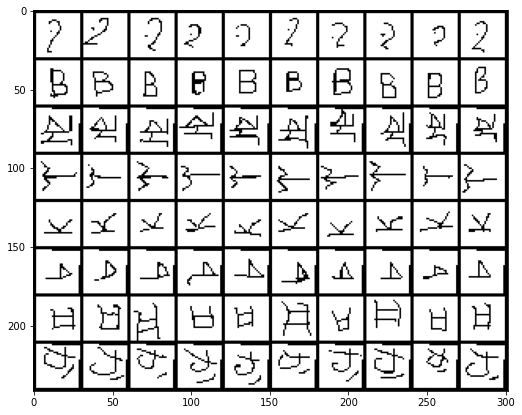

In [ ]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [ ]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

In [ ]:
temp = dict() # {label:img1, img2..., 20 imgs, label2: img1, img2,... in total, 1623 label}

In [ ]:
for (img, label) in ds:
  if label in temp.keys(): 
    temp[label].append(img)
  else: 
    temp[label] = [img]

AttributeError: ignored

In [ ]:
len(temp)

964

In [ ]:
ds = []

In [ ]:
for label, imgs in temp.items(): # labels info deserted , each label contains 20imgs
  ds.append(np.array(imgs))

In [ ]:
ds = np.array(ds).astype(np.float) # [[20 imgs],..., 1623 classes in total]

In [ ]:
# each character contains 20 imgs
print('data shape:', ds.shape) # [1623, 20, 84, 84, 1]

data shape: (964, 20, 1, 84, 84)


In [ ]:
temp = [] # Free memory

In [ ]:
ds_train, ds_test = ds[:1200], ds[1200:]

In [ ]:
len(ds_train), len(ds_test)

(964, 0)

image.shape: torch.Size([1, 105, 105])
Label: 0


19280

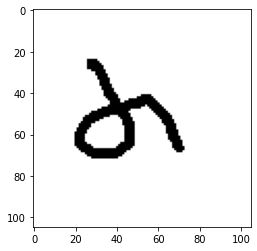

In [ ]:
%matplotlib inline
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0],cmap='gray')
print('Label:', label)
len(dataset)

In [ ]:
def split_indices(n, test_percentage):
  # Determine size of test set
  n_test = int(test_percentage*n)
  # Create random permutation of 0 to n-1
  idxs = np.random.permutation(n)
  # Pick first n_test indices for test set
  return idxs[n_test:], idxs[:n_test]

In [ ]:
train_indices, test_indices = split_indices(len(dataset), test_percentage=.2)
print(len(train_indices), len(test_indices))
print('Sample test indices: ', test_indices[:20])

15424 3856
Sample test indices:  [ 2247 16641  3557  3230 14350   614  4876  3999 14459  8493  5451  9993
  2449 15385 16276 18856 17646  8595 14122 15830]


image.shape: torch.Size([1, 105, 105])
Label: 688


19280

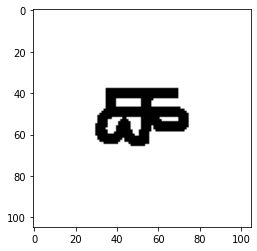

In [ ]:
from torch.utils.data import random_split
batch_size = 100

training_data, test_data = random_split(dataset, [len(train_indices), len(test_indices)])
len(training_data), len(test_ds)
image, label = training_data[0]
print('image.shape:', image.shape)
plt.imshow(image[0],cmap='gray')
print('Label:', label)
len(dataset)

In [ ]:
# len(train_ds), len(test_ds)

# # Training sampler and data loader 
# train_sampler = SubsetRandomSampler(train_indices)
# train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)

# # Test sampler and data loader 
# test_sampler = SubsetRandomSampler(test_indices)
# test_dl = DataLoader(dataset, batch_size, sampler=test_sampler)